In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [339]:
#Remove columns with more than 10% Nas
train = pd.read_csv('train.csv')
null_data = train.isnull().sum()
null_to_remove = null_data[null_data>len(null_data)*0.1].index.tolist()
train = train.drop(null_to_remove,1)

In [340]:
#Look at only columns with intergers 
data_type = train.dtypes
int_columns = data_type[data_type == 'int64'].index.tolist()
int_train = train[int_columns[1:-1]]


In [341]:
#combining SF to make total SF
int_train['TotalSF'] = int_train['1stFlrSF'] + int_train['2ndFlrSF']+ int_train['TotalBsmtSF']
int_train.drop(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'],1, inplace=True)

/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


array([[   7, 1710,    2,    2,  548, 2566],
       [   6, 1262,    2,    2,  460, 2524],
       [   7, 1786,    2,    2,  608, 2706],
       ..., 
       [   7, 2340,    2,    1,  252, 3492],
       [   5, 1078,    1,    1,  240, 2156],
       [   5, 1256,    1,    1,  276, 2512]])

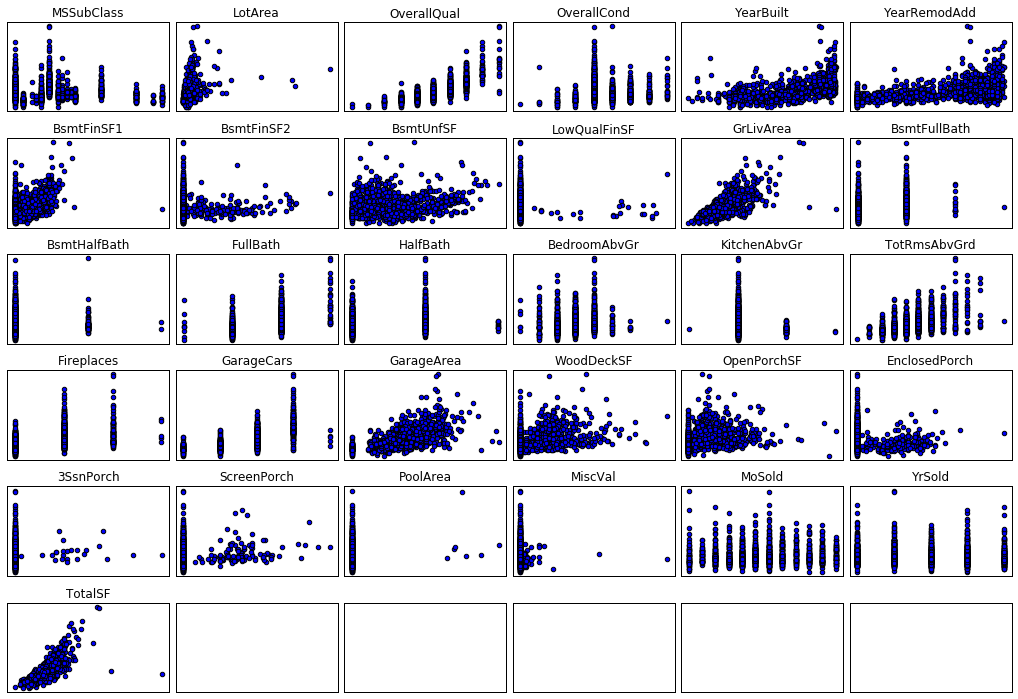

In [342]:
#graph and look at correlations. Select for parameters with r**2 value over 0.3
from scipy import stats
num_col = len(int_train.columns)
graph_dimension = int(round(math.sqrt(num_col)))

f, ax = plt.subplots(graph_dimension, graph_dimension,figsize=(18,12))
plt.subplots_adjust( hspace=0.3 )
plt.subplots_adjust( wspace=0.04 )

y = train['SalePrice']
counter = 0

list_of_predictors =[]

for i in range(graph_dimension):
    for j in range(graph_dimension):
        ax[i][j].get_yaxis().set_ticks([])
        ax[i][j].get_xaxis().set_ticks([])
        if counter >= num_col:
            continue
        else:
            x = int_train.iloc[:, counter]
            ax[i][j].scatter(x,y)
            ax[i][j].set_title(int_train.columns.values[counter])
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
            
            if r_value**2 > 0.3:
                list_of_predictors.append(int_train.columns.values[counter])
            counter = counter + 1

final_int_train = int_train[list_of_predictors]
final_int_train.values

In [343]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold



KeyError: "['TotalSF'] not in index"

In [326]:
x_train= final_int_train.values
y = train['SalePrice']

In [327]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y, test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=10)

lr = linear_model.LinearRegression()
lr.fit(x_train,y_train.ravel().T)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [328]:
pred_t = lr.predict(test_normed)
print pred_t
output = raw_test[['Id']]
output['SalePrice']=pred_t

NameError: name 'test_normed' is not defined